# Skeleton Notebook Deep Q-Learning Project (MHBF)

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/MHBF-DeepQ-Learning/gym_grid/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import required packages
import gym
import gym_grid

import matplotlib.pyplot as plt

import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython import display
from collections import namedtuple, deque
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

cpu


# 0. Environment Implementation

In [4]:
!pip install pycolab

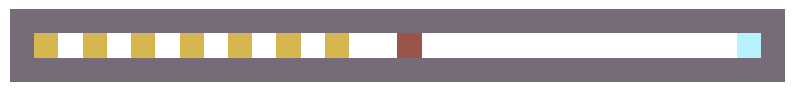

In [5]:
# Visualize the environment
plt.figure(figsize=(10, 10))
# T-Maze Environment
env = gym.make("LinearTrack-v0")
#env = gym.make("DeadlyGrid-v0")
_, obs_to_render = env.reset_with_render()
env.reset()
env.render(obs_to_render)

In [6]:
print('State space: ', env.observation_space)
print('State shape: ', env.observation_space.shape)
print('Action space: ', env.action_space)
print('Number of actions: ', env.action_space.n)

State space:  Box(0, 1, (3, 32, 4), uint8)
State shape:  (3, 32, 4)
Action space:  Discrete(3)
Number of actions:  3


# 1. Definition of model and params

In [7]:
# Discount factor
GAMMA = 0.99
# Learning rate
LEARNING_RATE = 0.001
# Capacity of the replay buffer
BUFFER_SIZE = 1000
# Update target net every ... episodes
UPDATE_EVERY= 500
# Batch size
BATCH_SIZE = 128
# Eval Episode
EVAL_EPISODE = 500
# Number of eval
N_EVAL = 50
# Hidden Units
HIDDEN_UNITS = 128
# Hidden layers
HIDDEN_LAYERS = 1
# Number of training episodes
N_EPISODES = 30000
# Initial value of epsilon
EPSILON_START = 1.0
# End value of epsilon
EPSILON_END = 0.01
# Epsilon decay
EPSILON_DECAY = (EPSILON_START - EPSILON_END) / N_EPISODES
# Initial value of epsilon
BETA_START = 0.4
# End value of epsilon
BETA_END = 1.0
# Epsilon decay
BETA_DECAY = (BETA_START - BETA_END) / N_EPISODES
# SEED
SEED = 1

params = {'gamma': GAMMA, 'lr': LEARNING_RATE, 'bacth_size': BATCH_SIZE,
          'buffer_size': BUFFER_SIZE, 'update_step': UPDATE_EVERY,
          'hidden_unit': HIDDEN_UNITS, 'hidden_laye': HIDDEN_LAYERS,'n_episode': N_EPISODES}

In [8]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units, hidden_layers):
        super(DQN, self).__init__()

        self.action_space_size = output_dim
        self.hidden_layers = hidden_layers
        self.layer_in = nn.Linear(input_dim, hidden_units)
        self.hidden_layer= nn.Linear(hidden_units, hidden_units)
        self.layer_out = nn.Linear(hidden_units, output_dim)

    def forward(self, x):
        x = F.relu(self.layer_in(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden_layer(x))
        x = self.layer_out(x)
        return x

    def action(self, state, epsilon):
        if random.random() > epsilon:
            q_value = self.forward(state)
            action  = int(torch.argmax(q_value, dim=-1))
        else:
            action = random.randrange(self.action_space_size)
        return action

In [9]:
def test_agent(model, gamma):
    done = False
    episode_return = 0
    i = 0
    state = torch.tensor(env.reset(), dtype=torch.float32).flatten().to(device)
    with torch.no_grad():
        while not done:
            action = model.action(state, 0)
            state, reward, done, info = env.step(action)
            state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
            episode_return += gamma**i * reward
            i += 1
    return episode_return

In [10]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

# 2. Baseline

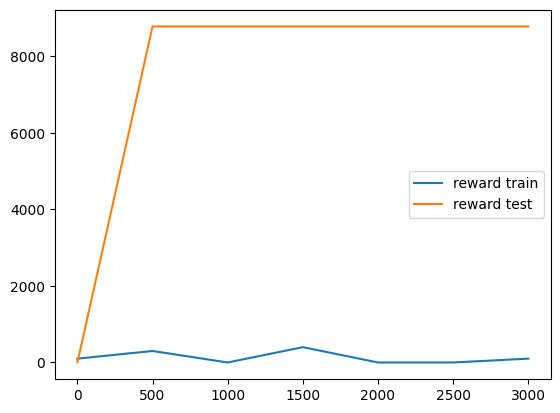

 10%|█         | 3103/30000 [00:45<07:39, 58.50it/s]

In [ ]:
set_seed(SEED)
model_baseline = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                     env.action_space.n,
                     HIDDEN_UNITS,
                     HIDDEN_LAYERS).to(device)
optimizer = optim.Adam(params=model_baseline.parameters(), lr=LEARNING_RATE)

results_baseline = {
    'params' : params,
    'epochs_save' : [],
    'weights': {},
    'rewards_test': [],
    'rewards_train': []
}

step = 0
eps = EPSILON_START

for step in tqdm(range(N_EPISODES)):
    done = False
    state = torch.tensor(env.reset(), dtype=torch.float32).flatten().to(device)
    r_train = 0
    result_train = []
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
    while not done:
        action = model_baseline.action(state, eps)
        next_state, reward, done, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).flatten().to(device)
        r_train += reward
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        dones.append(done)
        state = next_state

    states = torch.stack(states).to(device)
    actions = torch.tensor(actions).to(device)
    rewards = torch.tensor(rewards).to(device)
    next_states = torch.stack(next_states).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    next_state_values = model_baseline(next_state).max().detach()
    state_action_values = model_baseline(state)[action]

    expected_q_value = reward + GAMMA * next_state_values * (1 - done)
    loss = nn.MSELoss()(state_action_values, expected_q_value)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    result_train.append(r_train)

    if step%EVAL_EPISODE == 0:
        r_test = []
        for j in range(N_EVAL):
            r = test_agent(model_baseline, GAMMA)
            r_test.append(r)

        results_baseline['weights'][step] = model_baseline.state_dict()
        results_baseline['rewards_test'].append(np.mean(r_test))
        results_baseline['rewards_train'].append(np.mean(result_train))
        result_train = []
        results_baseline['epochs_save'].append(step)

        display.clear_output(True)
        plt.plot(results_baseline['epochs_save'], results_baseline['rewards_train'], label = "reward train")
        plt.plot(results_baseline['epochs_save'], results_baseline['rewards_test'], label = "reward test")
        plt.legend()
        plt.show()

    eps -= EPSILON_DECAY
    step += 1
torch.save(results_baseline, 'results_baseline.pth')

In [ ]:
state, obs_to_render = env.reset_with_render()
state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_baseline.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 3. Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, data_names, buffer_size, batch_size):
        self.data_keys = data_names
        self.data_dict = {}
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.reset()

    def reset(self):
        for name in self.data_keys:
            self.data_dict[name] = deque(maxlen=self.buffer_size)

    def push(self, data):
        """Add a transition to the buffer."""
        for key in self.data_keys:
            self.data_dict[key].append(data[key])

    def sample(self):
        """Sample a batch of transitions."""
        indices = random.sample(range(len(self)), self.batch_size)
        batch = [{key: self.data_dict[key][i] for key in self.data_keys} for i in indices]
        return batch

    def __len__(self):
        return len(next(iter(self.data_dict.values())))

In [ ]:
set_seed(SEED)
model_replay_buffer = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

replay_buffer = ReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'],
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_replay_buffer.parameters(), lr=LEARNING_RATE)

step = 0

results_rb = {
    'params' : params,
    'epochs_save' : [],
    'weights': {},
    'rewards_test': [],
    'rewards_train': []
}

eps = EPSILON_START
for step in tqdm(range(N_EPISODES)):
    done = False
    state = torch.tensor(env.reset(), dtype=torch.float32).flatten().to(device)
    result_train = []
    r_train = 0
    while not done:
        action = model_replay_buffer.action(state, eps)
        next_state, reward, done, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).flatten().to(device)
        replay_buffer.push({'state':state, 'action':action, 'reward':reward,
                            'next_state':next_state, 'done':done})
        r_train += reward

    result_train.append(r_train)

    if len(replay_buffer) >= replay_buffer.batch_size:
        batch = replay_buffer.sample()

        states = torch.stack([b['state'] for b in batch]).to(device)
        actions = torch.tensor([b['action'] for b in batch]).to(device)
        rewards = torch.tensor([b['reward'] for b in batch]).to(device)
        next_states = torch.stack([b['next_state'] for b in batch]).to(device)
        dones = torch.tensor([b['done'] for b in batch], dtype=torch.float32).to(device)

        state_action_values = model_replay_buffer(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_state_values = model_replay_buffer(next_states).max(1)[0].detach()
        expected_q_values = rewards + GAMMA * next_state_values * (1 - dones)

        loss = nn.MSELoss()(state_action_values, expected_q_value)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if step%EVAL_EPISODE == 0:
        r_test = []
        for j in range(10):
            r = test_agent(model_replay_buffer, GAMMA)
            r_test.append(r)
        results_rb['weights'][step] = model_replay_buffer.state_dict()
        results_rb['rewards_test'].append(np.mean(r_test))
        results_rb['rewards_train'].append(np.mean(result_train))
        result_train = []
        results_rb['epochs_save'].append(step)

        display.clear_output(True)
        plt.plot(results_rb['epochs_save'], results_rb['rewards_train'], label = "reward train")
        plt.plot(results_rb['epochs_save'],results_rb['rewards_test'], label = "reward test")
        plt.legend()
        plt.show()

    eps -= EPSILON_DECAY
    step += 1
torch.save(results_rb, 'results_rb.pth')

In [ ]:
state, obs_to_render = env.reset_with_render()
state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_replay_buffer.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 4. Target Network

In [ ]:
set_seed(SEED)
model_tn = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_tn_target = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_tn_target.load_state_dict(model_tn.state_dict())

replay_buffer = ReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'],
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_tn.parameters(), lr=LEARNING_RATE)

step = 0

results_tm = {
    'params' : params,
    'epochs_save' : [],
    'weights': {},
    'rewards_test': [],
    'rewards_train': []
}

eps = EPSILON_START
for step in tqdm(range(N_EPISODES)):
    done = False
    state = torch.tensor(env.reset(), dtype=torch.float32).flatten().to(device)
    r_train = 0
    result_train = []
    while not done:
        action = model_tn.action(state, eps)
        next_state, reward, done, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).flatten().to(device)
        replay_buffer.push({'state':state, 'action':action, 'reward':reward,
                            'next_state':next_state, 'done':done})
        r_train += reward

    result_train.append(r_train)

    if len(replay_buffer) >= replay_buffer.batch_size:
        batch = replay_buffer.sample()

        states = torch.stack([b['state'] for b in batch]).to(device)
        actions = torch.tensor([b['action'] for b in batch]).to(device)
        rewards = torch.tensor([b['reward'] for b in batch]).to(device)
        next_states = torch.stack([b['next_state'] for b in batch]).to(device)
        dones = torch.tensor([b['done'] for b in batch], dtype=torch.float32).to(device)

        state_action_values = model_tn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_state_values = model_tn_target(next_states).max(1)[0].detach()
        expected_q_values = rewards + GAMMA * next_state_values * (1 - dones)

        loss = nn.MSELoss()(state_action_values, expected_q_value)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if step % UPDATE_EVERY == 0:
        model_tn_target.load_state_dict(model_tn.state_dict())

    if step%EVAL_EPISODE == 0:
        r_test = []
        for j in range(10):
            r = test_agent(model_tn, GAMMA)
            r_test.append(r)
        results_tm['weights'][step] = model_tn.state_dict()
        results_tm['rewards_test'].append(np.mean(r_test))
        results_tm['epochs_save'].append(step)
        results_tm['rewards_train'].append(np.mean(result_train))
        result_train = []

        display.clear_output(True)
        plt.plot(results_tm['epochs_save'], results_tm['rewards_train'], label = "reward train")
        plt.plot(results_tm['epochs_save'], results_tm['rewards_test'], label = "reward test")
        plt.legend()
        plt.show()

    eps -= EPSILON_DECAY
torch.save(results_tm, 'results_tm.pth')

In [ ]:
state, obs_to_render = env.reset_with_render()
state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_tn.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 5. Loss Function Comparaison

In [ ]:
set_seed(SEED)
model_lf = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_lf_target = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_lf_target.load_state_dict(model_lf.state_dict())

replay_buffer = ReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'],
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_lf.parameters(), lr=LEARNING_RATE)

results_lf = {
    'params' : params,
    'epochs_save' : [],
    'weights': {},
    'rewards_test': [],
    'rewards_train': []
}

step = 0
eps = EPSILON_START
for step in tqdm(range(N_EPISODES)):
    done = False
    state = torch.tensor(env.reset(), dtype=torch.float32).flatten().to(device)
    r_train = 0
    result_train = []
    while not done:
        action = model_lf.action(state, eps)
        next_state, reward, done, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).flatten().to(device)
        replay_buffer.push({'state':state, 'action':action, 'reward':reward,
                            'next_state':next_state, 'done':done})
        r_train += reward

    result_train.append(r_train)

    if len(replay_buffer) >= replay_buffer.batch_size:
        batch = replay_buffer.sample()

        states = torch.stack([b['state'] for b in batch]).to(device)
        actions = torch.tensor([b['action'] for b in batch]).to(device)
        rewards = torch.tensor([b['reward'] for b in batch]).to(device)
        next_states = torch.stack([b['next_state'] for b in batch]).to(device)
        dones = torch.tensor([b['done'] for b in batch], dtype=torch.float32).to(device)

        state_action_values = model_lf(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_state_values = model_lf_target(next_states).max(1)[0].detach()
        expected_q_values = rewards + GAMMA * next_state_values * (1 - dones)

        loss = nn.SmoothL1Loss()(state_action_values, expected_q_value)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if step % UPDATE_EVERY == 0:
        model_lf_target.load_state_dict(model_lf.state_dict())

    if step%EVAL_EPISODE == 0:
        r_test = []
        for j in range(10):
            r = test_agent(model_lf, GAMMA)
            r_test.append(r)
        results_lf['weights'][step] = model_lf.state_dict()
        results_lf['rewards_test'].append(np.mean(r_test))
        results_lf['epochs_save'].append(step)
        results_lf['rewards_train'].append(np.mean(result_train))
        result_train = []

        display.clear_output(True)
        plt.plot(results_lf['epochs_save'], results_lf['rewards_train'], label = "reward train")
        plt.plot(results_lf['epochs_save'], results_lf['rewards_test'], label = "reward test")
        plt.legend()
        plt.show()

    eps -= EPSILON_DECAY
    step += 1
torch.save(results_lf, 'results_lf.pth')

In [ ]:
state, obs_to_render = env.reset_with_render()
state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_lf.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 6. Prioritized Experience Replay

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, data_names, buffer_size, batch_size, alpha=0.6):
        self.data_keys = data_names
        self.data_dict = {}
        self.buffer_size = buffer_size
        self.alpha = alpha
        self.priorities = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.reset()

    def reset(self):
        for name in self.data_keys:
            self.data_dict[name] = deque(maxlen=self.buffer_size)
        self.priorities = deque(maxlen=self.buffer_size)

    def push(self, data):
        """Add a transition to the buffer."""
        max_priority = max(self.priorities, default=1.0)
        self.priorities.append(max_priority)
        for key in self.data_keys:
            self.data_dict[key].append(data[key])

    def sample(self, beta=0.4):
        """Sample a batch of transitions."""
        if len(self) == self.buffer_size:
            priorities = np.array(self.priorities, dtype=np.float32)
            scaled_priorities = priorities ** self.alpha
            sample_probs = scaled_priorities / sum(scaled_priorities)
        else:
            sample_probs = np.ones(len(self)) / len(self)

        indices = np.random.choice(len(self), self.batch_size, p=sample_probs)
        samples = [{key: self.data_dict[key][i] for key in self.data_keys} for i in indices]

        weights = (len(self) * sample_probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, weights, indices

    def update_priorities(self, indices, td_errors):
        for i, td_error in zip(indices, td_errors):
            self.priorities[i] = abs(td_error) + 1e-6

    def __len__(self):
        return len(next(iter(self.data_dict.values())))

In [ ]:
set_seed(SEED)
model_per = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_per_target = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_per_target.load_state_dict(model_per.state_dict())

replay_buffer = PrioritizedReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'],
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_per.parameters(), lr=LEARNING_RATE)

results_per = {
    'params' : params,
    'epochs_save' : [],
    'weights': {},
    'rewards_test': [],
    'rewards_train': []
}

step = 0
eps  = EPSILON_START
beta = BETA_START
for step in tqdm(range(N_EPISODES)):
    done = False
    state = torch.tensor(env.reset(), dtype=torch.float32).flatten().to(device)
    r_train = 0
    while not done:
        action = model_per.action(state, eps)
        next_state, reward, done, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).flatten().to(device)
        replay_buffer.push({'state':state, 'action':action, 'reward':reward,
                            'next_state':next_state, 'done':done})
        r_train += reward

    results_per['rewards_train'].append(r_train)

    if len(replay_buffer) > replay_buffer.batch_size:
        batch, weights, indices = replay_buffer.sample(beta)
        for b in batch:

            next_state_values = model_per_target(b['next_state']).max().detach()
            state_action_values = model_per(b['state'])[b['action']]

            expected_q_value = b['reward'] + GAMMA * next_state_values * (1 - b['done'])

            td_errors = state_action_values - expected_q_value
            loss = torch.mean((state_action_values - expected_q_value ** 2) * weights)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            replay_buffer.update_priorities(indices, td_errors.detach().cpu().numpy())

    if step % UPDATE_EVERY == 0:
        model_per_target.load_state_dict(model_per.state_dict())

    if step%EVAL_EPISODE == 0:
        r_test = []
        for j in range(10):
            r = test_agent(model_per, GAMMA)
            r_test.append(r)
        results_per['weights'][step] = model_per.state_dict()
        results_per['rewards_test'].append(np.mean(r_test))
        results_per['epochs_save'].append(step)

        display.clear_output(True)
        plt.plot(results_per['rewards_train'], label = "reward train")
        plt.plot(results_per['epochs_save'], results_per['rewards_test'], label = "reward test")
        plt.legend()
        plt.show()

    eps -= EPSILON_DECAY
    step += 1
    beta = min(1.0, beta + BETA_DECAY)
torch.save(results_per, 'results_per.pth')